<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
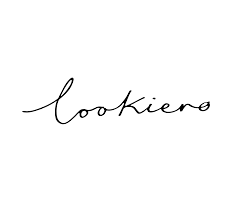    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Productos *best seller* por línea y categoría - Tendencias de marketing
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import glob
import os

- **Pyspark**

In [2]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import split, lit

* **Visualización**

In [3]:
import matplotlib.pyplot as plt

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [4]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [5]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return spark.read.csv(os.path.join(dir_in, nombre_tabla + ".csv"), header = True)

In [6]:
cd = carga_datos ()

### Datos a utlilizar
---

In [7]:
df_envios = cd.subir_una_tabla(dir_in, 'datos_envios_MU')
df_total  = cd.subir_una_tabla(dir_out, 'df_total')

df = df_total.join(df_envios, df_total.id == df_envios.id).drop('id')
df = df.withColumn('id_product', f.concat(f.col('family_product'), lit('_'), f.col('color') , lit('_'), f.col('size_lookiero')))

### Análisis de los productos *best sellers*
---

In [8]:
paleta = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']

* Adecual el *dataframe* a utilizar

In [9]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

In [10]:
df = df.withColumn('categoria', f.col('family_product'))
df = df.na.replace(niveles, 'categoria')
df = df.withColumn("family_product", split(f.col("id_product"), "_").getItem(0))
df = df.withColumn('linea', df.categoria.substr(0, 1))

C:\Users\Daniel\anaconda3\envs\reto10_rojo\lib\site-packages\pyspark\sql\dataframe.py:2233: UserWarning: to_replace is a dict and value is not None. value will be ignored.
  warnings.warn("to_replace is a dict and value is not None. value will be ignored.")


### *Best seller* por línea
---

In [11]:
import numpy as np
df2 = df.toPandas()
df2.linea = df2.categoria
df2.categoria = np.where(df2.categoria == '3.2', 'complementos', 'prendas')

lineas = {
    '1.1': 'tronco_entero',
    '1.2': 'tronco_inferior',
    '2.1': 'tronco_superior_interior',
    '2.2': 'tronco_superior_interior',
    '3.1': 'tronco_superior_exterior',
    '3.2': 'complementos'
}
df2.linea = df2.linea.map(lineas)

df2.loc[df2.id_product.str.split('_').str[0] == 'bag', 'linea'] = 'mochila'
df2.loc[df2.id_product.str.split('_').str[0] == 'scarf', 'linea'] = 'bufanda'

df3 = spark.createDataFrame(df2)

In [12]:
lineas = sorted([e[0] for e in df3.select('linea').distinct().collect()])
categorias = sorted([e[0] for e in df3.select('categoria').distinct().collect()])

In [13]:
df3.show()

+------+-----+-----------+-------------+----------+--------------------+--------------+----------+--------------+------+------+------------+--------------------+
|season|stock|publishable|size_lookiero|     color|          id_product|family_product|name_brand|  origin_brand|envios|ventas|   categoria|               linea|
+------+-----+-----------+-------------+----------+--------------------+--------------+----------+--------------+------+------+------------+--------------------+
|     7|    0|       True|            L| grey_dark|    coat_grey_dark_L|          coat|   BRAND15|    WHOLE_SALE|   110|    44|     prendas|tronco_superior_e...|
|     7|    0|       True|            M| grey_dark|    coat_grey_dark_M|          coat|   BRAND15|    WHOLE_SALE|   374|    22|     prendas|tronco_superior_e...|
|     7|    0|       True|            S| grey_dark|    coat_grey_dark_S|          coat|   BRAND15|    WHOLE_SALE|   638|   154|     prendas|tronco_superior_e...|
|     7|    0|       True|  

* **Best seller families por línea**

In [14]:
jontxu = df3.select('linea').distinct().toPandas()

In [15]:
total = pd.DataFrame()
for linea in jontxu.linea:

    df2 = df3.filter(df3.linea == linea).drop('linea', 'categoria')
    escrito = 'línea ' + linea

    suma_ventas = df2.groupby('id_product').agg({'ventas': 'sum'}).withColumnRenamed('sum(ventas)', 'suma_ventas').toPandas()
    suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]
    suma10 = suma_ventas.sort_values('suma_ventas', ascending = False).head(10)
    suma10['linea'] = linea
    total = pd.concat([total, suma10])

# colores = [paleta[6]] * 3 + [paleta[0]] * 7
# fig, ax = plt.subplots(figsize = (16, 8))

# ax.bar(suma10.id_product, suma10.suma_ventas, align = 'center', alpha = 0.8, ecolor = 'black', color = paleta[0])
# ax.set_facecolor('white')
# plt.title(f'Top 10 de los best sellers de la linea {linea}', fontweight = 'bold')
# plt.xlabel('Producto')
# plt.ylabel('Total de ventas')
# plt.xticks(rotation = 45)
# plt.show()

C:\Users\Daniel\AppData\Local\Temp/ipykernel_7360/2637870287.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]


In [16]:
total.reset_index(drop = True).to_csv('barras_por_linea.csv')

In [17]:
def best_seller_top10(linea, l = True):
    
    if l: 
        df2 = df3.filter(df3.linea == linea).drop('linea', 'categoria')
        escrito = 'línea ' + linea
    else:
        df2 = df3.filter(df3.categoria == linea).drop('linea', 'categoria')
        escrito = 'Categoría ' + linea
        
    suma_ventas = df2.groupby('id_product').agg({'ventas': 'sum'}).withColumnRenamed('sum(ventas)', 'suma_ventas').toPandas()
    suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]
    suma10 = suma_ventas.sort_values('suma_ventas', ascending = False).head(10)
    
    colores = [paleta[6]] * 3 + [paleta[0]] * 7
    fig, ax = plt.subplots(figsize = (16, 8))

    ax.bar(suma10.id_product, suma10.suma_ventas, align = 'center', alpha = 0.8, ecolor = 'black', color = paleta[0])
    ax.set_facecolor('white')
    plt.title(f'Top 10 de los best sellers de la linea {linea}', fontweight = 'bold')
    plt.xlabel('Producto')
    plt.ylabel('Total de ventas')
    plt.xticks(rotation = 45)
    plt.show()
    
    
def best_seller_family(linea, l = True):
    
    if l: 
        df2 = df3.filter(df3.linea == linea).drop('linea', 'categoria')
        escrito = 'línea ' + linea
    else:
        df2 = df3.filter(df3.categoria == linea).drop('linea', 'categoria')
        escrito = 'Categoría ' + linea
    
    suma_ventas = df2.groupby('family_product').agg({'ventas': 'sum'}).withColumnRenamed('sum(ventas)', 'suma_ventas').toPandas()
    suma_ventas['porcentaje'] = (suma_ventas.suma_ventas / suma_ventas.suma_ventas.sum()) * 100

    from math import pi

    categories = list(suma_ventas.family_product)
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar = True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([5, 10, 15], ["5%", "10%", "15%"], color = "grey", size = 10)

    values = suma_ventas.porcentaje.values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth = 1, linestyle = 'solid', color = paleta[0])
    ax.fill(angles, values, paleta[0], alpha = 0.15)


    plt.title(f'Best seller por familia ({escrito})')
    plt.show()

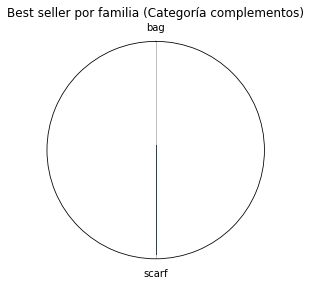

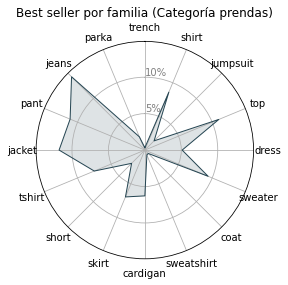

[None, None]

In [18]:
list(map(best_seller_family, categorias, [False] * len(categorias)))

* **Los 10 mejores productos por línea**

In [ ]:
def best_seller_top10(linea, l = True):
    
    if l: 
        df2 = df3.filter(df3.linea == linea).drop('linea', 'categoria')
        escrito = 'línea ' + linea
    else:
        df2 = df3.filter(df3.categoria == linea).drop('linea', 'categoria')
        escrito = 'Categoría ' + linea
        
    suma_ventas = df2.groupby('id_product').agg({'ventas': 'sum'}).withColumnRenamed('sum(ventas)', 'suma_ventas').toPandas()
    suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]
    suma10 = suma_ventas.sort_values('suma_ventas', ascending = False).head(10)
    
    colores = [paleta[6]] * 3 + [paleta[0]] * 7
    fig, ax = plt.subplots(figsize = (16, 8))

    ax.bar(suma10.id_product, suma10.suma_ventas, align = 'center', alpha = 0.8, ecolor = 'black', color = paleta[0])
    ax.set_facecolor('white')
    plt.title(f'Top 10 de los best sellers de la linea {linea}', fontweight = 'bold')
    plt.xlabel('Producto')
    plt.ylabel('Total de ventas')
    plt.xticks(rotation = 45)
    plt.show()
    

In [45]:
def best_seller_top10(linea, l = True):
    
    if l: 
        df2 = df3.filter(df3.linea == linea).drop('linea', 'categoria')
        escrito = 'línea ' + linea
    else:
        df2 = df3.filter(df3.categoria == linea).drop('linea', 'categoria')
        escrito = 'Categoría ' + linea
        
    suma_ventas = df2.groupby('id_product').agg({'ventas': 'sum'}).withColumnRenamed('sum(ventas)', 'suma_ventas').toPandas()
    suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]
    suma10 = suma_ventas.sort_values('suma_ventas', ascending = False).head(10)
    return suma10 

In [26]:
df3.select('linea').distinct().collect()

[Row(linea='tronco_entero'),
 Row(linea='tronco_superior_interior'),
 Row(linea='mochila'),
 Row(linea='tronco_superior_exterior'),
 Row(linea='tronco_inferior'),
 Row(linea='bufanda')]

In [56]:
lista = []
for x in ['tronco_entero', 'tronco_superior_interior','mochila','tronco_superior_exterior','tronco_inferior','bufanda']:
    aa = best_seller_top10(x, l = True)
    lista += [list(aa['id_product'].values)]
    lista += [list(aa['suma_ventas'].values)]

C:\Users\Daniel\AppData\Local\Temp/ipykernel_7360/3934509181.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]


In [59]:
df_tendencias = pd.DataFrame(lista).T

In [61]:
df_tendencias.columns = ['producto_tronco_entero', 'count_tronco_entero', 'producto_tronco_superior_interior', 'count_tronco_superior_interior', 'producto_mochila', 'count_mochila', 'producto_tronco_superior_exterior', 'count_tronco_superior_exterior', 'producto_tronco_inferior', 'count_tronco_inferior', 'producto_bufanda', 'count_bufanda']

In [63]:
df_tendencias.to_csv(dir_out + 'tendencias.csv')

In [58]:
lista[0]

['Dress Black M',
 'Dress Black S',
 'Dress Black L',
 'Dress Blue Dark L',
 'Dress Blue Dark M',
 'Dress Blue Dark S',
 'Dress Black XL',
 'Jumpsuit Blue Dark S',
 'Jumpsuit Black S',
 'Jumpsuit Black M']

In [42]:
pd.concat([aa, bb], axis = 1)

,index,id_product,suma_ventas,index,id_product,suma_ventas
0,12,Dress Black M,50350.0,687,Top Black M,71154.0
1,34,Dress Black S,46412.0,745,Top Black S,69263.0
2,122,Dress Black L,39443.0,764,Top Black L,60076.0
3,147,Dress Blue Dark L,33392.0,269,Sweater Blue Dark M,45374.0
4,43,Dress Blue Dark M,31128.0,520,Top Blue Dark M,42473.0
5,149,Dress Blue Dark S,26289.0,310,Top White S,41701.0
6,97,Dress Black XL,18391.0,601,Shirt Black M,40825.0
7,89,Jumpsuit Blue Dark S,16607.0,409,Sweater Blue Dark S,39878.0
8,232,Jumpsuit Black S,16123.0,125,Top Blue Dark S,39878.0
9,186,Jumpsuit Black M,15839.0,389,Top White M,38206.0


In [20]:
categorias

['complementos', 'prendas']

C:\Users\Daniel\AppData\Local\Temp/ipykernel_7360/2682223318.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]


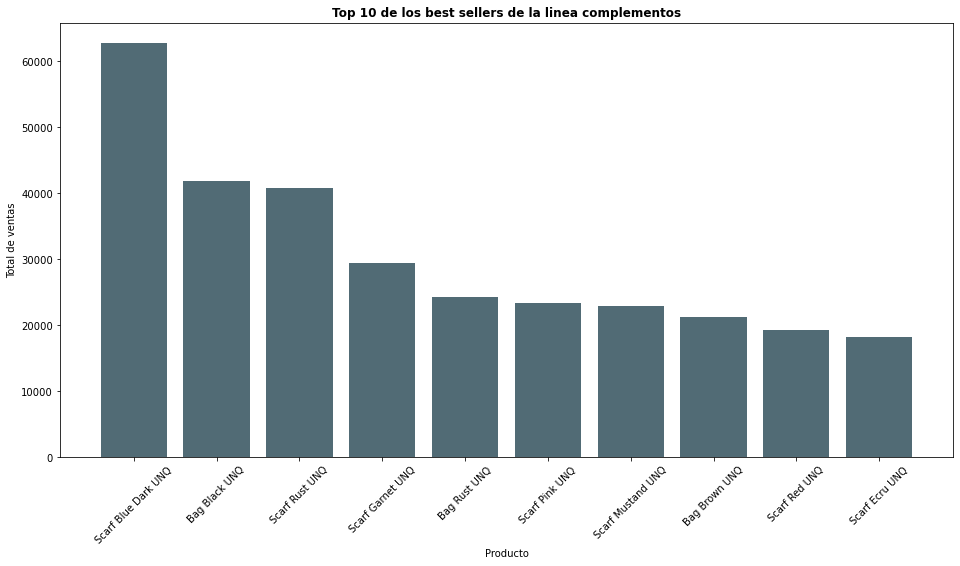

C:\Users\Daniel\AppData\Local\Temp/ipykernel_7360/2682223318.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  suma_ventas.id_product = suma_ventas.id_product.str.replace('_', ' ').str.replace('[A-Z]', '').str.title() + suma_ventas.id_product.str.split('_').str[-1]


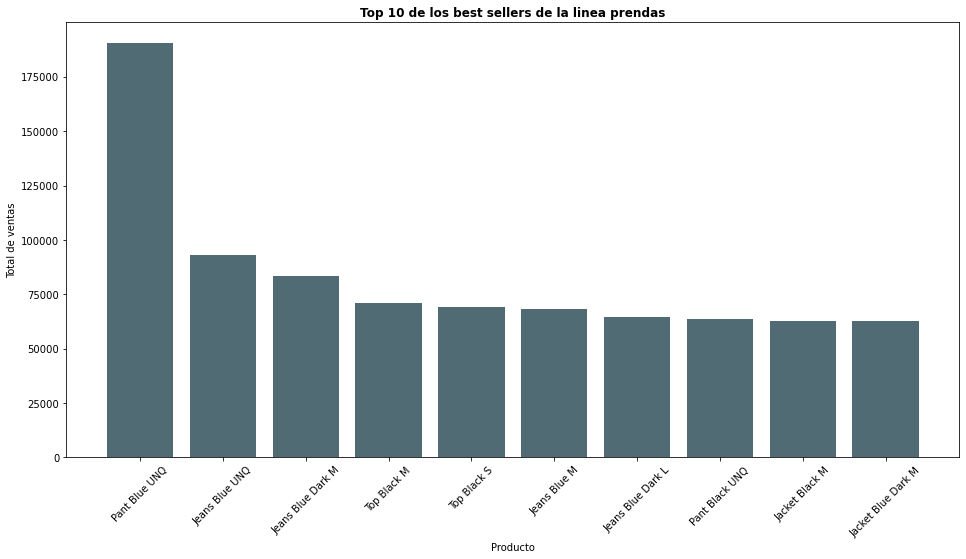

[None, None]

In [19]:
list(map(best_seller_top10, categorias, [False] *len(categorias)))

---